# MEPP Walkthrough: Motif Enrichment Positional Profiling
This notebook will walk you through how to perform a score based motif enrichment analysis that profiles motif enrichment at multiple positions across a set of sequences centered on biologically relevant features, in this case a central binding motif of interest. 

## Quickstart
If you already have MEPP installed, have a scored BED file, and want to quickly get started, jump to the section ["Convert scored bed file to scored sequences, and run MEPP analysis"](#Convert-scored-bed-file-to-scored-sequences,-and-run-MEPP-analysis)

# Install prerequisites

You will need the following prerequisites:
* MEPP
* HOMER
* pandas
* numpy
* gtfparse
* coolbox
* wget
* samtools
* deeptools
* bedtools
* bedops
* wiggletools
* wigToBigWig
* bigWigToWig
* tensorflow

To install most of these through mamba:
```
mamba create -d -n mepp_walkthrough -c bioconda -c conda-forge homer pandas numpy gtfparse coolbox wget samtools deeptools bedtools bedops wiggletools ucsc-wigtobigwig ucsc-bigwigtowig tensorflow
```

To install most of these through conda (slower):
```
conda create -d -n mepp_walkthrough -c bioconda -c conda-forge homer pandas numpy coolbox wget samtools deeptools bedtools bedops wiggletools ucsc-wigtobigwig ucsc-bigwigtowig tensorflow
```

To activate the environment:
```
conda activate mepp_walkthrough
```

To install MEPP, use pip:
```
pip install git+https://github.com/npdeloss/mepp@main
```

Or, if you only have user privileges:
```
pip install git+https://github.com/npdeloss/mepp@main --user
```

You may need to append the following to your ~/.bashrc:
```
export PATH="$HOME/.local/bin:$PATH"
```

# Import key libraries

In [1]:
import pandas as pd
import numpy as np

# Enumerate sample sheet with alignment files for download
Here we will be comparing K562 and HCT116 cell lines from ENCODE.

In [2]:
%%file k562.vs.hct116.atac-seq.samples.txt
cell_type replicate bam_url
k562 1 https://www.encodeproject.org/files/ENCFF512VEZ/@@download/ENCFF512VEZ.bam
k562 2 https://www.encodeproject.org/files/ENCFF987XOV/@@download/ENCFF987XOV.bam
hct116 1 https://www.encodeproject.org/files/ENCFF724QHH/@@download/ENCFF724QHH.bam
hct116 2 https://www.encodeproject.org/files/ENCFF927YUB/@@download/ENCFF927YUB.bam
hepg2 1 https://www.encodeproject.org/files/ENCFF239RGZ/@@download/ENCFF239RGZ.bam
hepg2 2 https://www.encodeproject.org/files/ENCFF394BBD/@@download/ENCFF394BBD.bam
dnd-41 1 https://www.encodeproject.org/files/ENCFF538YYI/@@download/ENCFF538YYI.bam
dnd-41 2 https://www.encodeproject.org/files/ENCFF080WSN/@@download/ENCFF080WSN.bam
dnd-41 3 https://www.encodeproject.org/files/ENCFF626KDS/@@download/ENCFF626KDS.bam

Overwriting k562.vs.hct116.atac-seq.samples.txt


# Load sample sheet

In [3]:
samplesheet_filepath = 'k562.vs.hct116.atac-seq.samples.txt'
samplesheet_sep = ' '

In [4]:
samplesheet_df = pd.read_csv(samplesheet_filepath, sep = samplesheet_sep)
samplesheet_df['sample'] = True
samplesheet_df

,cell_type,replicate,bam_url,sample
0,k562,1,https://www.encodeproject.org/files/ENCFF512VE...,True
1,k562,2,https://www.encodeproject.org/files/ENCFF987XO...,True
2,hct116,1,https://www.encodeproject.org/files/ENCFF724QH...,True
3,hct116,2,https://www.encodeproject.org/files/ENCFF927YU...,True
4,hepg2,1,https://www.encodeproject.org/files/ENCFF239RG...,True
5,hepg2,2,https://www.encodeproject.org/files/ENCFF394BB...,True
6,dnd-41,1,https://www.encodeproject.org/files/ENCFF538YY...,True
7,dnd-41,2,https://www.encodeproject.org/files/ENCFF080WS...,True
8,dnd-41,3,https://www.encodeproject.org/files/ENCFF626KD...,True


# Download Alignment files

In [5]:
samplesheet_df['basename'] = samplesheet_df['cell_type'] + '_rep' + samplesheet_df['replicate'].astype(str)
samplesheet_df['bam_filepath'] = samplesheet_df['basename'] + '.bam'

In [6]:
samplesheet_df['wget_bam_cmd'] = (
    'wget -nc -O ' +
    samplesheet_df['bam_filepath'] + ' ' +
    '"' + samplesheet_df['bam_url'] + '"'
)

In [7]:
%%time

run_wget_bam_cmds = run_cmd = True
for cmd in list(samplesheet_df['wget_bam_cmd']):
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O k562_rep1.bam "https://www.encodeproject.org/files/ENCFF512VEZ/@@download/ENCFF512VEZ.bam"
File ‘k562_rep1.bam’ already there; not retrieving.
wget -nc -O k562_rep2.bam "https://www.encodeproject.org/files/ENCFF987XOV/@@download/ENCFF987XOV.bam"
File ‘k562_rep2.bam’ already there; not retrieving.
wget -nc -O hct116_rep1.bam "https://www.encodeproject.org/files/ENCFF724QHH/@@download/ENCFF724QHH.bam"
File ‘hct116_rep1.bam’ already there; not retrieving.
wget -nc -O hct116_rep2.bam "https://www.encodeproject.org/files/ENCFF927YUB/@@download/ENCFF927YUB.bam"
File ‘hct116_rep2.bam’ already there; not retrieving.
wget -nc -O hepg2_rep1.bam "https://www.encodeproject.org/files/ENCFF239RGZ/@@download/ENCFF239RGZ.bam"
File ‘hepg2_rep1.bam’ already there; not retrieving.
wget -nc -O hepg2_rep2.bam "https://www.encodeproject.org/files/ENCFF394BBD/@@download/ENCFF394BBD.bam"
File ‘hepg2_rep2.bam’ already there; not retrieving.
wget -nc -O dnd-41_rep1.bam "https://www.encodeproject.org

# Index alignment files
Necessary to generate bigWig files

In [8]:
index_bam_threads = 8
samplesheet_df['index_bam_cmd'] = (
    'samtools index ' +
    samplesheet_df['bam_filepath']
)

In [9]:
%%time

run_index_bam_cmds = run_cmd = True
for cmd in list(samplesheet_df['index_bam_cmd']):
    print(cmd)
    if run_cmd:
        ! {cmd}

samtools index k562_rep1.bam
samtools index k562_rep2.bam
samtools index hct116_rep1.bam
samtools index hct116_rep2.bam
samtools index hepg2_rep1.bam
samtools index hepg2_rep2.bam
samtools index dnd-41_rep1.bam
samtools index dnd-41_rep2.bam
samtools index dnd-41_rep3.bam
CPU times: user 1.88 s, sys: 451 ms, total: 2.33 s
Wall time: 3min 27s


# Compute coverage bigWig files from alignment files
You will need to use [effective genome size](https://deeptools.readthedocs.io/en/latest/content/feature/effectiveGenomeSize.html) numbers for the relevant genome.
You could also use other normalizations of choice at this step. Here we use the deeptools `bamCoverage` defaults.
These will allow you to later visualize and quantify calculations on this coverage data.

In [10]:
effective_genome_size = 2913022398
bamcoverage_binsize = 10
bamcoverage_threads = 'max/2'
# Value for GRCh38, from:
# https://deeptools.readthedocs.io/en/latest/content/feature/effectiveGenomeSize.html

In [11]:
samplesheet_df['bw_filepath'] = samplesheet_df['basename'] + '.bw'
samplesheet_df['raw_bw_filepath'] = samplesheet_df['basename'] + '.raw.bw'

In [12]:
samplesheet_df['bamcoverage_cmd'] = (
    f'bamCoverage ' + 
    f' -p {bamcoverage_threads} ' + 
    f' --effectiveGenomeSize {effective_genome_size} ' + 
    f' --normalizeUsing RPKM '
    f' -bs {bamcoverage_binsize}'
    f' -b ' + samplesheet_df['bam_filepath'] + 
    f' -o ' + samplesheet_df['bw_filepath']
)

samplesheet_df['bamcoverage_raw_cmd'] = (
    f'bamCoverage ' + 
    f' -p {bamcoverage_threads} ' + 
    f' --effectiveGenomeSize {effective_genome_size} ' + 
    f' --normalizeUsing None '
    f' -bs {bamcoverage_binsize}'
    f' -b ' + samplesheet_df['bam_filepath'] + 
    f' -o ' + samplesheet_df['raw_bw_filepath']
)

bamcoverage_cmds = list(samplesheet_df['bamcoverage_cmd']) + list(samplesheet_df['bamcoverage_raw_cmd'])

In [13]:
%%time

run_bamcoverage_cmds = run_cmd = True
for cmd in bamcoverage_cmds:
    print(cmd)
    if run_cmd:
        ! {cmd}

bamCoverage  -p max/2  --effectiveGenomeSize 2913022398  --normalizeUsing RPKM  -bs 10 -b k562_rep1.bam -o k562_rep1.bw
normalization: RPKM
bamFilesList: ['k562_rep1.bam']
binLength: 10
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 28
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 10
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
bamCoverage  -p max/2  --effectiveGenomeSize 2913022398  --normalizeUsing RPKM  -bs 10 -b k562_rep2.bam -o k562_rep2.bw
normalization: RPKM
bamFilesList: ['k562_rep2.bam']
binLength: 10
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragm

# Download reference genome
Also generate index and chromosome size files for bedtools and wigToBigWig

In [14]:
genome_fa_filepath = 'hg38.fa'
genome_fai_filepath = f'{genome_fa_filepath}.fai'
genome_chromsizes_filepath = f'{genome_fa_filepath}.chromsizes.tab'
genome_fa_gz_url = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.masked.gz'

In [15]:
download_genome_fa_cmd = f'wget -nc -O {genome_fa_filepath}.gz "{genome_fa_gz_url}"; zcat {genome_fa_filepath}.gz > {genome_fa_filepath}'

In [16]:
index_genome_fa_cmd = f'samtools faidx {genome_fa_filepath}'
genome_chromsizes_cmd = f'cut -f1,2 {genome_fai_filepath} > {genome_chromsizes_filepath}'

In [17]:
%%time

run_download_genome_fa_cmd = run_cmd = True
for cmd in [download_genome_fa_cmd, index_genome_fa_cmd, genome_chromsizes_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O hg38.fa.gz "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/latest/hg38.fa.masked.gz"; zcat hg38.fa.gz > hg38.fa
File ‘hg38.fa.gz’ already there; not retrieving.
samtools faidx hg38.fa
cut -f1,2 hg38.fa.fai > hg38.fa.chromsizes.tab
CPU times: user 277 ms, sys: 87.4 ms, total: 365 ms
Wall time: 31.2 s


# Designate comparison
Here we compare HCT116 vs. K562 cells. Comparison groups are designated by the `cell_type` column.

In [18]:
group_1  = 'hct116'
group_2  = 'k562'

group_column = 'cell_type'
sample_column = 'sample'
sort_column = 'replicate'

comparison_prefix = f'{group_1}.vs.{group_2}'


In [19]:
print(comparison_prefix)

hct116.vs.k562


# List bigwigs belonging to each group

In [20]:
sample_subset_df = samplesheet_df[samplesheet_df[sample_column]].sort_values(by = sort_column).copy()

group_1_sample_bw_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_1]['bw_filepath'])
group_2_sample_bw_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_2]['bw_filepath'])
sample_bw_filepaths = group_1_sample_bw_filepaths + group_2_sample_bw_filepaths
group_1_sample_bw_filepaths_str = ' '.join(group_1_sample_bw_filepaths)
group_2_sample_bw_filepaths_str = ' '.join(group_2_sample_bw_filepaths)
sample_bw_filepaths_str = ' '.join(sample_bw_filepaths)

group_1_sample_raw_bw_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_1]['raw_bw_filepath'])
group_2_sample_raw_bw_filepaths = list(sample_subset_df[sample_subset_df[group_column] == group_2]['raw_bw_filepath'])
sample_raw_bw_filepaths = group_1_sample_raw_bw_filepaths + group_2_sample_raw_bw_filepaths
group_1_sample_raw_bw_filepaths_str = ' '.join(group_1_sample_raw_bw_filepaths)
group_2_sample_raw_bw_filepaths_str = ' '.join(group_2_sample_raw_bw_filepaths)
sample_raw_bw_filepaths_str = ' '.join(sample_raw_bw_filepaths)

# Calculate Bigwig of Log2FC between groups.
First we calculate the means of each group, in `{group_1}.mean.bw` and `{group_2}.mean.bw`. Then we compute the Log2 Fold Change (with pseudocount) as `log2((group_1_mean+1)/(group_2_mean+1))`. A pseudocount prevents division by zero in the ratio calculation.

We also compute the sum of coverage across all samples, for use later.

In [21]:
group_1_bw_filepath = f'{group_1}.mean.bw'
group_2_bw_filepath = f'{group_2}.mean.bw'

sum_bw_filepath = f'{group_1}.vs.{group_2}.sum.bw'
log2fc_bw_filepath = f'{group_1}.vs.{group_2}.log2fc.bw'

In [22]:
group_1_bw_cmd = (
    f'wiggletools write {group_1_bw_filepath}.wig mean {group_1_sample_bw_filepaths_str} ; '
    f'wigToBigWig -clip {group_1_bw_filepath}.wig {genome_chromsizes_filepath} {group_1_bw_filepath} ; '
    f'rm {group_1_bw_filepath}.wig'
)
group_2_bw_cmd = (
    f'wiggletools write {group_2_bw_filepath}.wig mean {group_2_sample_bw_filepaths_str} ; '
    f'wigToBigWig -clip {group_2_bw_filepath}.wig {genome_chromsizes_filepath} {group_2_bw_filepath} ; '
    f'rm {group_2_bw_filepath}.wig'
)

sum_bw_cmd = (
    f'wiggletools write {sum_bw_filepath}.wig sum {group_1_sample_raw_bw_filepaths_str} {group_2_sample_raw_bw_filepaths_str} ; '
    f'wigToBigWig -clip {sum_bw_filepath}.wig {genome_chromsizes_filepath} {sum_bw_filepath} ; '
    f'rm {sum_bw_filepath}.wig'
)

log2fc_bw_cmd = (
    f'wiggletools write {group_1_bw_filepath}.plus_1.wig offset 1 {group_1_bw_filepath} ; '
    f'wiggletools write {group_2_bw_filepath}.plus_1.wig offset 1 {group_2_bw_filepath} ; '
    f'wiggletools write {group_1}.vs.{group_2}.ratio.wig ratio {group_1_bw_filepath}.plus_1.wig {group_2_bw_filepath}.plus_1.wig ; '
    f'wiggletools write {log2fc_bw_filepath}.wig log 2 {group_1}.vs.{group_2}.ratio.wig ; '
    f'wigToBigWig -clip {log2fc_bw_filepath}.wig {genome_chromsizes_filepath} {log2fc_bw_filepath} ; '
    f'rm {group_1_bw_filepath}.plus_1.wig ; '
    f'rm {group_2_bw_filepath}.plus_1.wig ; '
    f'rm {group_1}.vs.{group_2}.ratio.wig ; '
    f'rm {log2fc_bw_filepath}.wig '
)

In [23]:
bw_cmds = [group_1_bw_cmd, group_2_bw_cmd, sum_bw_cmd, log2fc_bw_cmd]

In [24]:
%%time

run_bw_cmds = run_cmd = True
for cmd in list(bw_cmds):
    print(cmd)
    if run_cmd:
        ! {cmd}

wiggletools write hct116.mean.bw.wig mean hct116_rep1.bw hct116_rep2.bw ; wigToBigWig -clip hct116.mean.bw.wig hg38.fa.chromsizes.tab hct116.mean.bw ; rm hct116.mean.bw.wig
chromosome chrEBV is not in chrom sizes file
chromosome chrEBV is not in chrom sizes file
wiggletools write k562.mean.bw.wig mean k562_rep1.bw k562_rep2.bw ; wigToBigWig -clip k562.mean.bw.wig hg38.fa.chromsizes.tab k562.mean.bw ; rm k562.mean.bw.wig
chromosome chrEBV is not in chrom sizes file
chromosome chrEBV is not in chrom sizes file
wiggletools write hct116.vs.k562.sum.bw.wig sum hct116_rep1.raw.bw hct116_rep2.raw.bw k562_rep1.raw.bw k562_rep2.raw.bw ; wigToBigWig -clip hct116.vs.k562.sum.bw.wig hg38.fa.chromsizes.tab hct116.vs.k562.sum.bw ; rm hct116.vs.k562.sum.bw.wig
chromosome chrEBV is not in chrom sizes file
chromosome chrEBV is not in chrom sizes file
wiggletools write hct116.mean.bw.plus_1.wig offset 1 hct116.mean.bw ; wiggletools write k562.mean.bw.plus_1.wig offset 1 k562.mean.bw ; wiggletools write 

# Download annotation file
Not strictly necessary, just for the benefit of visualization

In [25]:
# genes_gtf_filepath = 'hg38_ensGene.gtf'
# genes_gtf_gz_url = 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.ensGene.gtf.gz'

genes_gtf_filepath = 'ENCFF159KBI.gtf'
genes_bed_filepath = genes_gtf_filepath[:-len('.gtf')]+'.bed'
genes_gtf_gz_url = 'https://www.encodeproject.org/files/ENCFF159KBI/@@download/ENCFF159KBI.gtf.gz'

In [26]:
download_genes_gtf_cmd = f'wget -nc -O {genes_gtf_filepath}.gz "{genes_gtf_gz_url}"; zcat {genes_gtf_filepath}.gz > {genes_gtf_filepath}'
# index_gtf_cmd = f'tabix -p gff {genes_gtf_filepath}'

In [27]:
%%time

run_download_genes_gtf_cmd = run_cmd = True
for cmd in [download_genes_gtf_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O ENCFF159KBI.gtf.gz "https://www.encodeproject.org/files/ENCFF159KBI/@@download/ENCFF159KBI.gtf.gz"; zcat ENCFF159KBI.gtf.gz > ENCFF159KBI.gtf
File ‘ENCFF159KBI.gtf.gz’ already there; not retrieving.
CPU times: user 51 ms, sys: 23.7 ms, total: 74.6 ms
Wall time: 5.25 s


In [28]:
! head {genes_gtf_filepath}

chr1	HAVANA	gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; level 2; havana_gene "OTTHUMG00000000961.2";
chr1	HAVANA	transcript	11869	14409	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "processed_transcript"; transcript_name "DDX11L1-202"; level 2; transcript_support_level "1"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	11869	12227	.	+	.	gene_id "ENSG00000223972.5"; transcript_id "ENST00000456328.2"; gene_type "transcribed_unprocessed_pseudogene"; gene_name "DDX11L1"; transcript_type "processed_transcript"; transcript_name "DDX11L1-202"; exon_number 1; exon_id "ENSE00002234944.1"; level 2; transcript_support_level "1"; tag "basic"; havana_gene "OTTHUMG00000000961.2"; havana_transcript "OTTHUMT00000362751.1";
chr1	HAVANA	exon	12613	12721	.	+	.

In [29]:
from gtfparse import read_gtf

In [30]:
genes_df = read_gtf(genes_gtf_filepath)
genes_df = genes_df[genes_df["feature"] == "gene"].copy()
genes_df = genes_df[['seqname', 'start', 'end', 'gene_name', 'score', 'strand']].copy()
genes_df['start'] = genes_df['start']-1
genes_df['score'] = 0
genes_df.to_csv(genes_bed_filepath, sep = '\t', index = False, header = None)
genes_df

/home/provnpd0/miniconda3/envs/mepp_walkthrough/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/provnpd0/miniconda3/envs/mepp_walkthrough/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


,seqname,start,end,gene_name,score,strand
0,chr1,11868,14409,DDX11L1,0,+
12,chr1,14403,29570,WASH7P,0,-
25,chr1,17368,17436,MIR6859-1,0,-
28,chr1,29553,31109,MIR1302-2HG,0,+
36,chr1,30365,30503,MIR1302-2,0,+
...,...,...,...,...,...,...
2742636,chr22_KI270734v1_random,72410,74814,AC007325.1,0,+
2742643,chr22_KI270734v1_random,131493,137392,AC007325.4,0,+
2742659,chr22_KI270734v1_random,138081,161852,AC007325.2,0,-
2742728,chrUn_KI270744v1,51008,51114,RF00026,0,-


# Visualize Log2 Fold Change bigWig with Coolbox

In [31]:
import coolbox
from coolbox.api import *

In [32]:
coolbox.__version__

'0.3.8'

In [33]:
genes_df[genes_df['gene_name']=='HBB']

,seqname,start,end,gene_name,score,strand
1422334,chr11,5225463,5229395,HBB,0,-


In [34]:
test_margin = 2000
test_gene_df=genes_df[genes_df['gene_name']=='HBB'].copy().reset_index(drop = True)
test_chr = list(test_gene_df['seqname'])[0]
test_start = list(test_gene_df['start'])[0] - test_margin
test_end = list(test_gene_df['end'])[0] + test_margin

[W::hts_idx_load3] The index file is older than the data file: ENCFF159KBI.bed.bgz.tbi


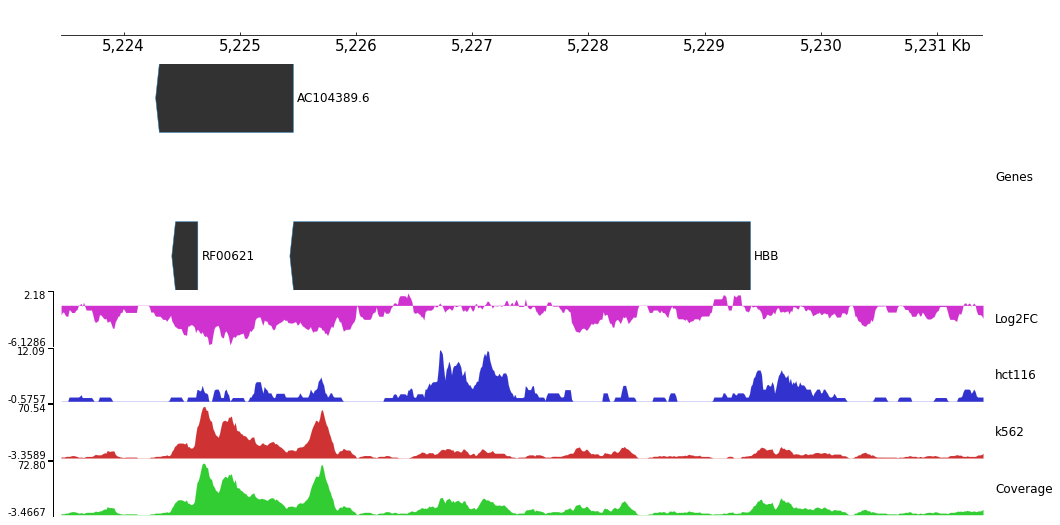

In [35]:
# test_range = 'chr9:5000000-5500000'
test_range = f'{test_chr}:{test_start}-{test_end}'
frame = (
    XAxis() + 
    BED(genes_bed_filepath) +
    Title('Genes') + TrackHeight(8) + Color('#323232') +
    BigWig(log2fc_bw_filepath) + Title('Log2FC') + Color('#cf32cf') +
    BigWig(group_1_bw_filepath) + Title(group_1) + Color('#3232cf') +
    BigWig(group_2_bw_filepath) + Title(group_2) + Color('#cf3232') +
    BigWig(sum_bw_filepath) + Title('Coverage') + Color('#32cd32')
)
frame.plot(test_range)
# bsr = Browser(frame)
# bsr.show()

# Copy over the HOMER motif library
Use the below commands to locate and copy your motif library if you installed HOMER with conda/mamba

In [36]:
copy_homer_motif_cmd = f'cp -rf $(dirname $(which homer))/../share/homer/motifs ./homer_motifs'

In [37]:
%%time

run_copy_homer_motif_cmd = run_cmd = True
for cmd in [copy_homer_motif_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

cp -rf $(dirname $(which homer))/../share/homer/motifs ./homer_motifs
CPU times: user 21 ms, sys: 19.9 ms, total: 40.9 ms
Wall time: 1.92 s


# Scan for motif instances to center sequence on

In [38]:
motif_basename = 'gata'

In [39]:
motif_subpath = '/'.join(motif_basename.split(' '))
motif_safe_basename = '_'.join(motif_subpath.split('/'))
scanned_motif_filepath = f'homer_motifs/{motif_subpath}.motif'
motif_scans_bed_filepath = f'{motif_safe_basename}.scans.bed'

In [40]:
scan_motifs_cmd = (
    f'scanMotifGenomeWide.pl {scanned_motif_filepath} {genome_fa_filepath} '
    f'-bed -5p 1> {motif_scans_bed_filepath} 2> {motif_scans_bed_filepath}.log'
)


In [41]:
%%time

run_scan_motifs_cmd = run_cmd = True
for cmd in [scan_motifs_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

scanMotifGenomeWide.pl homer_motifs/gata.motif hg38.fa -bed -5p 1> gata.scans.bed 2> gata.scans.bed.log
CPU times: user 2.28 s, sys: 497 ms, total: 2.78 s
Wall time: 4min 1s


In [42]:
! head {scanned_motif_filepath}

>CAGATAAGGN	Gata1(Zf)/K562-GATA1-ChIP-Seq(GSE18829)/Homer	6.402981	-6.924523e+03	0	50000.0,9843.0,7580.0,5717.0,0.00e+00
0.109	0.469	0.365	0.057
0.700	0.024	0.001	0.275
0.001	0.001	0.997	0.001
0.997	0.001	0.001	0.001
0.001	0.001	0.001	0.997
0.997	0.001	0.001	0.001
0.997	0.001	0.001	0.001
0.023	0.145	0.830	0.001
0.311	0.237	0.434	0.018


In [43]:
! head {motif_scans_bed_filepath}
! wc -l {motif_scans_bed_filepath}

chr1	22919	23119	Gata1(Zf)	8.474400	+
chr1	27984	28184	Gata1(Zf)	8.166325	-
chr1	32492	32692	Gata1(Zf)	8.746133	+
chr1	32657	32857	Gata1(Zf)	7.109025	-
chr1	42233	42433	Gata1(Zf)	8.746133	+
chr1	48006	48206	Gata1(Zf)	8.153403	-
chr1	50012	50212	Gata1(Zf)	9.838112	-
chr1	51059	51259	Gata1(Zf)	6.645415	-
chr1	53345	53545	Gata1(Zf)	9.020373	+
chr1	53472	53672	Gata1(Zf)	9.954682	+
525556 gata.scans.bed


# Score motif scans by Log2 Fold Change, and annotate with coverage

In [44]:
scored_motif_scans_filepath = f'{motif_safe_basename}.scans.scored_by.{log2fc_bw_filepath}.bed'
coverage_summed_motif_scans_filepath = f'{motif_safe_basename}.scans.scored_by.{sum_bw_filepath}.bed'

In [45]:
score_scans_cmd = f'bigWigToWig {log2fc_bw_filepath} >(wig2bed -x) | bedmap --echo --delim \'\\t\' --wmean {motif_scans_bed_filepath} - | awk \'$7!="NAN"\' | awk \'{{FS=OFS="\\t";$5=$7;print $1,$2,$3,$4,$5,$6}}\' > {scored_motif_scans_filepath}'

In [46]:
coverage_sum_scans_cmd = f'bigWigToWig {sum_bw_filepath} >(wig2bed -x) | bedmap --echo --delim \'\\t\' --wmean {scored_motif_scans_filepath} - > {coverage_summed_motif_scans_filepath}'

In [47]:
%%time

run_score_scans_cmds = run_cmd = True
for cmd in [score_scans_cmd, coverage_sum_scans_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

bigWigToWig hct116.vs.k562.log2fc.bw >(wig2bed -x) | bedmap --echo --delim '\t' --wmean gata.scans.bed - | awk '$7!="NAN"' | awk '{FS=OFS="\t";$5=$7;print $1,$2,$3,$4,$5,$6}' > gata.scans.scored_by.hct116.vs.k562.log2fc.bw.bed
bigWigToWig hct116.vs.k562.sum.bw >(wig2bed -x) | bedmap --echo --delim '\t' --wmean gata.scans.scored_by.hct116.vs.k562.log2fc.bw.bed - > gata.scans.scored_by.hct116.vs.k562.sum.bw.bed
CPU times: user 5.22 s, sys: 1.12 s, total: 6.34 s
Wall time: 8min 54s


In [48]:
! head {scored_motif_scans_filepath}

chr1	22919	23119	Gata1(Zf)	0.000000	+
chr1	27984	28184	Gata1(Zf)	0.000000	-
chr1	32492	32692	Gata1(Zf)	0.000000	+
chr1	32657	32857	Gata1(Zf)	-1.240453	-
chr1	42233	42433	Gata1(Zf)	-1.266769	+
chr1	48006	48206	Gata1(Zf)	-0.597903	-
chr1	50012	50212	Gata1(Zf)	1.776575	-
chr1	51059	51259	Gata1(Zf)	-0.454239	-
chr1	53345	53545	Gata1(Zf)	-1.884116	+
chr1	53472	53672	Gata1(Zf)	-1.961904	+


In [49]:
! head {coverage_summed_motif_scans_filepath}

chr1	22919	23119	Gata1(Zf)	0.000000	+	0.000000
chr1	27984	28184	Gata1(Zf)	0.000000	-	0.000000
chr1	32492	32692	Gata1(Zf)	0.000000	+	0.000000
chr1	32657	32857	Gata1(Zf)	-1.240453	-	2.175000
chr1	42233	42433	Gata1(Zf)	-1.266769	+	18.085000
chr1	48006	48206	Gata1(Zf)	-0.597903	-	2.710000
chr1	50012	50212	Gata1(Zf)	1.776575	-	2.940000
chr1	51059	51259	Gata1(Zf)	-0.454239	-	6.040000
chr1	53345	53545	Gata1(Zf)	-1.884116	+	8.875000
chr1	53472	53672	Gata1(Zf)	-1.961904	+	5.430000


# Perform cluster deduplication, designate sequence length
By default, HOMER genomewide motif scans extract intervals +/-100bp of the motif 5' end. This step prevents extraction of overlapping sequences in this interval, which prevents e.g. identification of artifactual periodicities/positionalities due to repetitive sequence. For example, you might have a motif repeat with itself within +/- 100bp of its own instances, giving rise to artificial periodicity due to repetitive sampling of the same genomic DNA.

Briefly, we cluster overlapping intervals, then for each cluster we select only the interval with the highest summed coverage across all samples.

We also only select intervals witha minimum summed coverage of 5, to avoid picking up unbound intervals.

In [50]:
sequence_length = 200

In [51]:
sequence_length = max(sequence_length, 200)
slop = (sequence_length-200)//2

In [52]:
cluster_deduplicated_scored_motif_scans_filepath = scored_motif_scans_filepath[:-len('.bed')] + '.cluster_deduplicated.bed'
slopped_cluster_deduplicated_scored_motif_scans_filepath = cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')] + f'.slop_{slop}.bed'

In [53]:
min_coverage = 5.0
cluster_deduplication_cmd = (
    f'bedtools cluster -s -i {coverage_summed_motif_scans_filepath} '
    f'|awk \'$7>={min_coverage}\' '
    f'| sort -k8,8n -k7,7nr | awk \'!a[$8]++\' '
    f'| bedtools sort -i - |cut -f1-6 '
    f'> {cluster_deduplicated_scored_motif_scans_filepath}'
)

slop_cmd = (
    f'bedtools slop -i {cluster_deduplicated_scored_motif_scans_filepath} -b {slop} -g {genome_chromsizes_filepath} > {slopped_cluster_deduplicated_scored_motif_scans_filepath}'
)



In [54]:
%%time

run_bedtools_cmds = run_cmd = True
for cmd in [cluster_deduplication_cmd, slop_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

bedtools cluster -s -i gata.scans.scored_by.hct116.vs.k562.sum.bw.bed |awk '$7>=5.0' | sort -k8,8n -k7,7nr | awk '!a[$8]++' | bedtools sort -i - |cut -f1-6 > gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.bed
bedtools slop -i gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.bed -b 0 -g hg38.fa.chromsizes.tab > gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.bed
CPU times: user 32.2 ms, sys: 41.5 ms, total: 73.7 ms
Wall time: 3.13 s


In [55]:
! head {slopped_cluster_deduplicated_scored_motif_scans_filepath}

chr1	42233	42433	Gata1(Zf)	-1.266769	+
chr1	51059	51259	Gata1(Zf)	-0.454239	-
chr1	53345	53545	Gata1(Zf)	-1.884116	+
chr1	67892	68092	Gata1(Zf)	-0.659711	-
chr1	632721	632921	Gata1(Zf)	-0.971672	-
chr1	796048	796248	Gata1(Zf)	-2.782733	+
chr1	796306	796506	Gata1(Zf)	-1.834608	+
chr1	797945	798145	Gata1(Zf)	-0.928542	-
chr1	801919	802119	Gata1(Zf)	-0.896669	+
chr1	803941	804141	Gata1(Zf)	-1.488721	+


# Preview BED file of scored intervals 

In [56]:
bed_columns = 'Chr Start End Name Score Strand'.split()
bed_df = pd.read_csv(cluster_deduplicated_scored_motif_scans_filepath, sep = '\t', header = None, names = bed_columns)
bed_df

,Chr,Start,End,Name,Score,Strand
0,chr1,42233,42433,Gata1(Zf),-1.266769,+
1,chr1,51059,51259,Gata1(Zf),-0.454239,-
2,chr1,53345,53545,Gata1(Zf),-1.884116,+
3,chr1,67892,68092,Gata1(Zf),-0.659711,-
4,chr1,632721,632921,Gata1(Zf),-0.971672,-
...,...,...,...,...,...,...
135692,chrY,15749872,15750072,Gata1(Zf),3.218434,-
135693,chrY,18459264,18459464,Gata1(Zf),2.937927,-
135694,chrY,18860933,18861133,Gata1(Zf),3.563321,+
135695,chrY,19566658,19566858,Gata1(Zf),2.996070,+


# Visualize score distribution
Like most tools, MEPP prefers normal score distributions.

array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

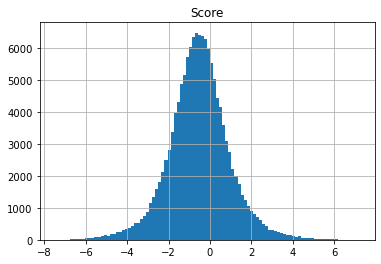

In [57]:
bed_df[['Score']].hist(bins=100)

# Download JASPAR-converted HOMER vertebrate motifs

In [58]:
motifs_url = 'https://raw.githubusercontent.com/npdeloss/mepp/main/data/homer.motifs.txt'
motifs_filepath = 'homer.motifs.txt'

In [59]:
wget_motifs_cmd = (
    f'wget -nc -O {motifs_filepath} "{motifs_url}"'
)

In [60]:
%%time

run_wget_motifs_cmds = run_cmd = True
for cmd in [wget_motifs_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

wget -nc -O homer.motifs.txt "https://raw.githubusercontent.com/npdeloss/mepp/main/data/homer.motifs.txt"
File ‘homer.motifs.txt’ already there; not retrieving.
CPU times: user 0 ns, sys: 25.6 ms, total: 25.6 ms
Wall time: 134 ms


# Convert scored bed file to scored sequences, and run MEPP analysis
In `mepp.get_scored_fasta` we handle reverse complementation of sequence according the BED interval's strand value. We can then pipe that directly into MEPP.

## Explanation of parameters

`python -m mepp.get_scored_fasta`
* Utility for extracting scored FASTA files (sequence score in header) from scored bed files
    * `-fi {genome_fa_filepath}`: Extract sequence from the specified genome FASTA (required).
    * `-bed {bed_filepath}`: Extract sequences from the intervals specified in this BED file (required). 
    
`|python -m mepp.cli`
* Pipe output from previous command into MEPP
    * `--fa - `: Receive scored FASTA from the output of the previous command (Required).
    * `--motifs {motifs_filepath}:` Analyze these motifs from a JASPAR-formatted motif matrix collection file (Required).
    * `--out {mepp_filepath} `: Output to this directory (Required).
    * `--perms 100 `: Use 100 permutations for confidence interval statistics (Default: 1000, can be costly in time & memory).
    * `--batch 1000`: Use 1000 as tensorflow batch size (Default: 1000, adjust according to machine memory)
    * `dgt 50`: Only analyze sequences with less than 50% degenerate base content (Default: 100, adjust according to analysis needs)
    * `--jobs 20`: Use 20 jobs for multithreaded tasks. (Default: Use all cores)
    * `--gjobs 20`: Use 20 jobs for multithreaded tasks optimizable by Tensorflow GPU usage. (Default: 1)
    * `--nogpu`: Don't use the GPU (Default: Use GPU.)
        * if set, `--gjobs` is simply the number of cores used to process motifs in parallel.
    * `--dpi 100`: DPI of plots. Important, since the motif occurrence heatmap is DPI-dependent. (Default: 300)
    * `--orientations +,- `: Analyze these orientations of the motifs (Forward, and reverse). (Default: +,+/-, analyze Forward, and non-orientation specific)
    * Not specified here:
        * ` --margin {INTEGER}`: Number of bases along either side of motif to "blur" motif matches for smoothing. (Default: 2)
            * It can be useful to set this depending on how strictly your sequences have been centered. If centering on ChIP-seq peak centers, consider a larger margin.

In [61]:
mepp_filepath = slopped_cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')]+f'.for_notebook.mepp'

mepp_cmd = (
    f'python -m mepp.get_scored_fasta -fi {genome_fa_filepath} '
    f'-bed {slopped_cluster_deduplicated_scored_motif_scans_filepath} '
    f'|python -m mepp.cli '
    f'--fa - '
    f'--motifs {motifs_filepath} '
    f'--out {mepp_filepath} '
    f'--perms 100 '
    f'--batch 1000 '
    f'--dgt 50 '
    f'--jobs 15 '
    f'--gjobs 15 '
    f'--nogpu '
    f'--dpi 100 '
    f'--orientations +,- '
    f'&> {mepp_filepath}.log'
)

In [62]:
%%time

run_mepp_cmd = run_cmd = True
for cmd in [mepp_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

python -m mepp.get_scored_fasta -fi hg38.fa -bed gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.bed |python -m mepp.cli --fa - --motifs homer.motifs.txt --out gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp --perms 100 --batch 1000 --dgt 50 --jobs 15 --gjobs 15 --nogpu --dpi 100 --orientations +,- &> gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp.log
/home/provnpd0/miniconda3/envs/mepp_walkthrough/lib/python3.9/runpy.py:127: RuntimeWarning: 'mepp.get_scored_fasta' found in sys.modules after import of package 'mepp', but prior to execution of 'mepp.get_scored_fasta'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
CPU times: user 36.6 s, sys: 6.93 s, total: 43.5 s
Wall time: 44min 24s


In [63]:
! tail {mepp_filepath}.log

/gpfs/data01/bennerlab/home/provnpd0/mepp_walkthrough/mepp/html.py:929: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='columns')`
  clustermap_df
/gpfs/data01/bennerlab/home/provnpd0/mepp_walkthrough/mepp/html.py:929: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  clustermap_df
/gpfs/data01/bennerlab/home/provnpd0/mepp_walkthrough/mepp/html.py:1049: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  f'''<body>{clustermap_df_style.render()}</body></html>'''
HTML result table for orientation +: gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/results_table_orientation_fwd.html
HTML result table for orientation -: gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/results_table_orientation_rev.html
HTML clustermap for orientation +: gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.me

# Show links to MEPP HTML outputs
MEPP outputs HTML files that are useful for visualizing and navigating your data

In [64]:
from IPython.display import display, Markdown

In [65]:

mepp_results_table_fwd_md = f'[Results table, + orientation]({mepp_filepath}/results_table_orientation_fwd.html)'
mepp_clustermap_fwd_md = f'[Clustermap, + orientation]({mepp_filepath}/clustermap_orientation_fwd.html)'

mepp_results_table_rev_md = f'[Results table, - orientation]({mepp_filepath}/results_table_orientation_rev.html)'
mepp_clustermap_rev_md = f'[Clustermap, - orientation]({mepp_filepath}/clustermap_orientation_rev.html)'

In [66]:
display(Markdown(mepp_results_table_fwd_md))
display(Markdown(mepp_clustermap_fwd_md))
display(Markdown(mepp_results_table_rev_md))
display(Markdown(mepp_clustermap_rev_md))

[Results table, + orientation](gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/results_table_orientation_fwd.html)

[Clustermap, + orientation](gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/clustermap_orientation_fwd.html)

[Results table, - orientation](gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/results_table_orientation_rev.html)

[Clustermap, - orientation](gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.mepp/clustermap_orientation_rev.html)

# Example commands for set-based analysis with CentriMo
Threshold top and bottom 10% of scored sequences, then use these as positive/negative inputs to set-based MEA, e.g. CentriMo

In [67]:
percent = 10
lower_percent = percent
higher_percent = 100.0-percent
lower_thresh, upper_thresh = list(np.percentile(bed_df['Score'], [lower_percent, higher_percent]))

In [68]:
upper_slopped_cluster_deduplicated_scored_motif_scans_filepath = cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')]+'.upper.bed'
lower_slopped_cluster_deduplicated_scored_motif_scans_filepath = cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')]+'.lower.bed'

upper_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath = cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')]+'.upper.fa'
lower_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath = cluster_deduplicated_scored_motif_scans_filepath[:-len('.bed')]+'.lower.fa'

In [69]:
upper_bed_df = bed_df[bed_df['Score']>=upper_thresh].copy()
lower_bed_df = bed_df[bed_df['Score']<=lower_thresh].copy()

In [70]:
upper_bed_df.to_csv(upper_slopped_cluster_deduplicated_scored_motif_scans_filepath, sep = '\t', index = False, header = None)
! head {upper_slopped_cluster_deduplicated_scored_motif_scans_filepath}

chr1	2768240	2768440	Gata1(Zf)	2.062406	-
chr1	2975991	2976191	Gata1(Zf)	1.317635	+
chr1	3068900	3069100	Gata1(Zf)	5.008648	+
chr1	3136583	3136783	Gata1(Zf)	1.676491	-
chr1	3320610	3320810	Gata1(Zf)	4.444686	+
chr1	3338527	3338727	Gata1(Zf)	2.035219	+
chr1	3613498	3613698	Gata1(Zf)	2.775806	-
chr1	4514654	4514854	Gata1(Zf)	2.017347	-
chr1	4514878	4515078	Gata1(Zf)	2.082657	+
chr1	4756973	4757173	Gata1(Zf)	1.206943	+


In [71]:
lower_bed_df.to_csv(lower_slopped_cluster_deduplicated_scored_motif_scans_filepath, sep = '\t', index = False, header = None)
! head {lower_slopped_cluster_deduplicated_scored_motif_scans_filepath}

chr1	796048	796248	Gata1(Zf)	-2.782733	+
chr1	831715	831915	Gata1(Zf)	-3.581281	-
chr1	842880	843080	Gata1(Zf)	-5.297722	+
chr1	1005019	1005219	Gata1(Zf)	-2.568964	-
chr1	1062591	1062791	Gata1(Zf)	-3.538543	+
chr1	1185582	1185782	Gata1(Zf)	-4.176309	-
chr1	2104986	2105186	Gata1(Zf)	-2.333475	-
chr1	2233029	2233229	Gata1(Zf)	-3.856457	+
chr1	2258765	2258965	Gata1(Zf)	-2.49223	-
chr1	2557016	2557216	Gata1(Zf)	-2.430786	+


In [72]:
upper_fa_cmd = ( f'python -m mepp.get_scored_fasta -fi {genome_fa_filepath} '
    f'-bed {upper_slopped_cluster_deduplicated_scored_motif_scans_filepath} '
    f'> {upper_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath}'
)

lower_fa_cmd = ( f'python -m mepp.get_scored_fasta -fi {genome_fa_filepath} '
    f'-bed {lower_slopped_cluster_deduplicated_scored_motif_scans_filepath} '
    f'> {lower_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath}'
)

In [73]:
%%time

run_thresh_fa_cmds = run_cmd = True
for cmd in [upper_fa_cmd, lower_fa_cmd]:
    print(cmd)
    if run_cmd:
        ! {cmd}

python -m mepp.get_scored_fasta -fi hg38.fa -bed gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.upper.bed > gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.upper.fa
/home/provnpd0/miniconda3/envs/mepp_walkthrough/lib/python3.9/runpy.py:127: RuntimeWarning: 'mepp.get_scored_fasta' found in sys.modules after import of package 'mepp', but prior to execution of 'mepp.get_scored_fasta'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
python -m mepp.get_scored_fasta -fi hg38.fa -bed gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.lower.bed > gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.lower.fa
/home/provnpd0/miniconda3/envs/mepp_walkthrough/lib/python3.9/runpy.py:127: RuntimeWarning: 'mepp.get_scored_fasta' found in sys.modules after import of package 'mepp', but prior to execution of 'mepp.get_scored_fasta'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
CPU times:

In [74]:
upper_bed_df.shape

(13570, 6)

In [75]:
lower_bed_df.shape

(13570, 6)

# Example equivalent Centrimo command

In [76]:
meme_motifs_filepath = 'homer.motifs.id_fixed.meme'
centrimo_filepath = mepp_filepath[:-len('.mepp')]+f'.upper_vs_lower.for_notebook.centrimo'
centrimo_cmd = (
    f'mkdir -p {centrimo_filepath} ;'
    f'$(which time) --verbose '
    f'centrimo --oc {centrimo_filepath} '
    f'--neg {lower_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath} '
    f'--norc --sep --local --noseq '
    f'{upper_slopped_cluster_deduplicated_scored_motif_scans_fa_filepath} '
    f'{meme_motifs_filepath}'
)
print(centrimo_cmd)

mkdir -p gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.upper_vs_lower.for_notebook.centrimo ;$(which time) --verbose centrimo --oc gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.slop_0.for_notebook.upper_vs_lower.for_notebook.centrimo --neg gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.lower.fa --norc --sep --local --noseq gata.scans.scored_by.hct116.vs.k562.log2fc.bw.cluster_deduplicated.upper.fa homer.motifs.id_fixed.meme
